<a href="https://colab.research.google.com/github/emdavis2/DurotaxisModeling/blob/main/SimpleDurotaxisModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we are going to model the Ornstein-Uhlenbeck process, a solution to the Langevin Equation (a stochastic differential equation), using the Euler-Maruyama method.

The Ornstein-Uhlenbeck process describes the stochastic evolution of a particle in a fluid under the influence of friction 

https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
sigma = 1. #standard deviation
mu = 10. #mean
tau = .05 #time constant

In [ ]:
dt = 0.001 #time step
T = 1. #total time
n = int(T/dt) #number of time steps
t = np.linspace(0., T, n) #vector of times

In [ ]:
sigma_bis = sigma * np.sqrt(2./tau)
sqrtdt = np.sqrt(dt)

In [ ]:
x = np.zeros(n)

In [ ]:
for i in range(n-1):
  x[i+1]=x[i] + dt * (-(x[i]-mu)/tau) + sigma_bis * sqrtdt * np.random.randn()

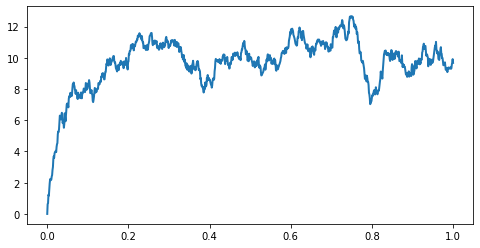

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(t, x, lw=2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


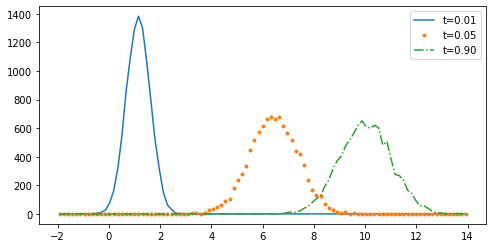

In [ ]:
ntrials = 10000
X = np.zeros(ntrials)

bins = np.linspace(-2., 14., 100)
fig, ax = plt.subplots(1, 1, figsize=(8,4))
for i in range(n):
  X += dt * (-(X - mu)/tau) + sigma_bis * sqrtdt * np.random.randn(ntrials)
  if i in (5,50,900):
    hist, _ = np.histogram(X, bins = bins)
    ax.plot((bins[1:] + bins[:-1]) / 2, hist,
                {5: '-', 50: '.', 900: '-.', }[i],
                label=f"t={i * dt:.2f}")
  ax.legend()

## Durotaxis Model in 1D

This model follows the Gillespeie algorithm and follows the paper from Malik and Gerlee (2019). We start off with a cell with randomly distributed focal adhesions, $x_{i} \in \mathbb{R}, i=1,...,n$. We compute the initial nucleus position through $X=\frac{1}{n}\sum_{i}x_{i}$. Each focal adhesion site has a corresponding rate parameter $\lambda_{i}=\beta + \gamma \frac{|u_{i}| - |\tilde{u}|}{\sum_{j} |u_{j}|}$ where $|u_{i}|=|\frac{F}{E(x_{i})}|$. For constant stiffness, $E$, we have $\lambda_{i}=\beta$ for all $i$ and we assume that the force exerted is the same at every adhesion site so the force term can be factored out and incorporated in the parameter $\gamma$, thus giving us $|u_{i}|=\frac{1}{E(x_{i})}$. We initialize the time at t=0 and specify some end tiem and begin the algorithm. While t is less than the specified end time, we do the following process:


1.   Compute $\lambda_{i}$ for each site $i$ and $\Lambda=\frac{1}{n}\sum_{i}\lambda_{i}$
2.   Compute time until next event such that $\tau \sim Exp(\Lambda)$
3. Generate a uniform random number $r \sim U([0,1])$. For each site, $i$, if $\frac{\lambda_{i-1}}{\Lambda} \leq r < \frac{\lambda_{i}}{\Lambda}$, update the position $x_{i}=N(X, \sigma^{2})$ of site $i$
4. Update the new nucleus position with $X=\frac{1}{n}\sum_{i}x_{i}$
5. Progress $t$ as $t=t+\tau$



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand

#rand.seed(10)

#define parameters
n = 3 #number of sites
sigma = 0.05 #std dev for normal dist
beta = 0.5
gamma = 1

#time range 
T = 10

In [ ]:
#stiffness function 
def E(x):
  return 3 + 0.9 * x

#nucleus position function
def nuc_pos(x, n):
  return (1/n) * np.sum(x)

#lambda for each position 
def lamb(Ex, n):
  lambda_is = []
  for i in range(n):
    u_i = np.abs(1/Ex[i])
    u_else = np.abs((1/(n-1)) * np.sum((1/np.array(Ex[0:i])).tolist() + (1/np.array(Ex[i+1:])).tolist()))
    lambda_is.append(beta + gamma * ((u_i - u_else)/np.sum(np.abs(1/np.array(Ex)))))
  return lambda_is

In [ ]:
#initialize positions
pos_FA = rand.sample(range(1,20),n)
pos_nuc = nuc_pos(pos_FA, n)

#create grid of stiffnesses in space
Ex = []
for i in range (n):
  Ex.append(E(pos_FA[i]))

In [ ]:
print(Ex)

[17.4, 12.9, 5.7]


In [ ]:
t = 0

Xlist = []
time = []

while t<T:
  time.append(t)
  Xlist.append(pos_nuc)
  Lambda = np.sum(lamb(Ex, n))
  t_next = np.random.exponential(scale = 1/Lambda)
  r = np.random.uniform()
  for i in range(1,n):
    lb = lamb(Ex, n)[i-1]/Lambda
    ub = lamb(Ex, n)[i]/Lambda
    if r >= lb and r < ub:
      pos_FA[i] = np.random.normal(pos_nuc, sigma**2)
      Ex[i] = E(pos_FA[i])
    else:
      continue
    pos_nuc = nuc_pos(pos_FA, n)
    t += t_next



Text(0, 0.5, 'nucleus position')

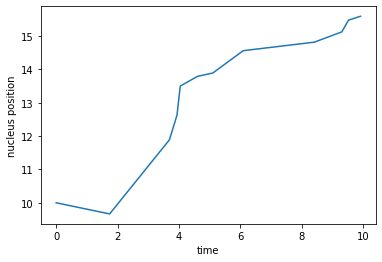

In [ ]:
plt.plot(time, Xlist)
plt.xlabel("time")
plt.ylabel('nucleus position')

In [ ]:
print(Ex)

[17.4, 17.03780759888737, 16.783036603249904]


## 1D Durotaxis model with next time of event given by $\tau = \Delta t \lambda$ rather than $\tau \sim Exp(\Lambda)$

Exponential distribution probability density function is given by $\lambda e^{-\lambda t}$ and the probability that an event happens in time interval $\Delta t$ is $P(t \leq \Delta t) = \int_{0}^{\Delta t} \lambda e^{-\lambda t}dt = 1-e^{-\Delta t \lambda}$. Taylor expanding this result, we get $1-e^{-\Delta t \lambda} \approx \Delta t \lambda$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand

#rand.seed(10)

#define parameters
n = 3 #number of sites
sigma = 0.05 #std dev for normal dist
beta = 0.5
gamma = 1

#time range 
T = 10

dt = .1

In [ ]:
#stiffness function 
def E(x):
  return 3 + 0.9 * x

#nucleus position function
def nuc_pos(x, n):
  return (1/n) * np.sum(x)

#lambda for each position 
def lamb(Ex, n):
  lambda_is = []
  for i in range(n):
    u_i = np.abs(1/Ex[i])
    u_else = np.abs((1/(n-1)) * np.sum((1/np.array(Ex[0:i])).tolist() + (1/np.array(Ex[i+1:])).tolist()))
    lambda_is.append(beta + gamma * ((u_i - u_else)/np.sum(np.abs(1/np.array(Ex)))))
  return lambda_is

In [ ]:
#initialize positions
pos_FA = rand.sample(range(1,20),n)
pos_nuc = nuc_pos(pos_FA, n)

#create grid of stiffnesses in space
Ex = []
for i in range (n):
  Ex.append(E(pos_FA[i]))

In [ ]:
t = 0

Xlist = []
time = []

while t<T:
  time.append(t)
  Xlist.append(pos_nuc)
  Lambda = np.sum(lamb(Ex, n))
  t_next = dt * Lambda
  r = np.random.uniform()
  for i in range(1,n):
    lb = lamb(Ex, n)[i-1]/Lambda
    ub = lamb(Ex, n)[i]/Lambda
    if r >= lb and r < ub:
      pos_FA[i] = np.random.normal(pos_nuc, sigma**2)
      Ex[i] = E(pos_FA[i])
    else:
      continue
    pos_nuc = nuc_pos(pos_FA, n)
    t += t_next



Text(0, 0.5, 'nucleus position')

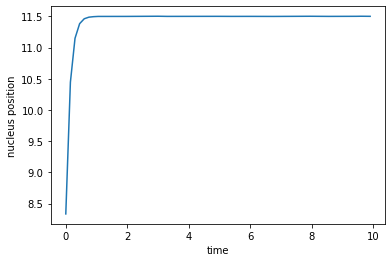

In [ ]:
plt.plot(time, Xlist)
plt.xlabel("time")
plt.ylabel('nucleus position')

## 2D Durotaxis model

Same model as 1D but in 2D

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand

#define parameters
n = 8 #number of sites
sigma = 0.05 #std dev for normal dist
beta = 0.5
gamma = 1

#time range 
T = 10

In [ ]:
#stiffness function 
def E(x):
  return 3 + 0.9 * x

#nucleus position function
def nuc_pos(x, n):
  return (1/n) * np.sum(x)

#lambda for each position 
def lamb(Ex, n):
  lambda_is = []
  for i in range(n):
    u_i = np.abs(1/Ex[i])
    u_else = np.abs((1/(n-1)) * np.sum((1/np.array(Ex[0:i])).tolist() + (1/np.array(Ex[i+1:])).tolist()))
    lambda_is.append(beta + gamma * ((u_i - u_else)/np.sum(np.abs(1/np.array(Ex)))))
  return lambda_is

In [ ]:
#initialize positions
pos_FA_x = rand.sample(range(1,20),n)
pos_nuc_x = nuc_pos(pos_FA_x, n)
pos_FA_y = rand.sample(range(1,20),n)
pos_nuc_y = nuc_pos(pos_FA_y, n)

#create grid of stiffnesses in space
Ex = []
for i in range (n):
  Ex.append(E(pos_FA_x[i]))

Ey = []
for i in range (n):
  Ey.append(E(pos_FA_y[i]))

In [ ]:
t = 0

Xlist = []
Ylist = []
time = []

while t<T:
  time.append(t)
  Xlist.append(pos_nuc_x)
  Ylist.append(pos_nuc_y)
  Exy = np.sqrt(Ex**2 + Ey**2)
  Lambda = np.sum(lamb(Exy, n))
  t_next = np.random.exponential(scale = 1/Lambda)
  r = np.random.uniform()
  for i in range(1,n):
    lb = lamb(Exy, n)[i-1]/Lambda
    ub = lamb(Exy, n)[i]/Lambda
    if r >= lb and r < ub:
      pos_FA[i] = np.random.normal(pos_nuc, sigma**2)
      Ex[i] = E(pos_FA[i])
    else:
      continue
    pos_nuc = nuc_pos(pos_FA, n)
    t += t_next



Text(0, 0.5, 'nucleus position')

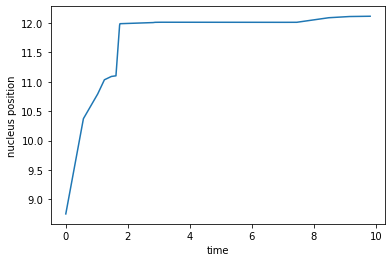

In [ ]:
plt.plot(time, Xlist)
plt.xlabel("time")
plt.ylabel('nucleus position')

In [ ]:
print(Ex)

[12.9, 8.4, 14.700000000000001, 16.5, 12.0, 17.4, 15.6, 6.6]


In [ ]:
print(pos_FA)

[11, 6, 13, 15, 10, 16, 14, 4]


In [ ]:
lamb(Ex)

TypeError: ignored